## 1. Знакомство с проектом и данными

#### Цель: 
"Для каждого client_id в наборе тестов ('test.csv') вы должны предсказать вероятность для default переменной. Итоговый файл должен содержать в заголовоке: 
* client_id - идентификатор заемщика;
* default - вероятность дефолта по кредиту."

Исходные данные представленные в виде обучающей выборки: train(73,799 записей) и тестовой: test(36,349 записей). Данные выборок хорошо сбалансированны по всем параметрам (пропорции классов в обоих файлах по всем параметрам сохраняются), но искомые классы в парамтре default не сбалансированны и представленны в пропорции: 12,7% / 87,3%

##### Учитывая, что искомые классы не сбалансированны, а так же то, что нас интересует максималый процент верных предсказаний по обеим классам - в качестве ключевой метрики для оценки точности будем использовать F-меру (ну и тем более по ней оценивается рейтинг в лидерборде!).

In [1]:
# импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from itertools import combinations, combinations_with_replacement

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


In [2]:
# подгрузим дополнительные настройки

import warnings
warnings.simplefilter('ignore')

# import matplotlib.pyplot as plt2
from matplotlib import pylab as plt
%matplotlib inline

pd.set_option('display.width', 140, 'display.max_columns', None)

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
SEED = 100

In [4]:
# функция обработки бинарных категориальных признаков (в бинарный числовой):
def binary_futures(*dfs, **columns_args):
    for df in dfs:
        for col, arg in columns_args.items():
            df[col] = (df[col] == arg).astype('int32')

#### Посмотрим на обучающие и тестовые данные:

In [5]:
DATA_DIR = '/kaggle/input/sf-scoring/'
train = pd.read_csv(DATA_DIR+'train.csv')
test = pd.read_csv(DATA_DIR+'/test.csv')

In [6]:
# Как видим в данных присутсвует 6 категориальных признаков, 12 числовых и один целевой параметр (в обучающей выборке): default - флаг дефолта по кредиту.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
print(train.shape)
train.sample(5)

(73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
23026,16110,23JAN2014,GRD,M,51,N,N,0,0,-2.056643,0,60,2,3,30000,1,3,N,0
30083,26199,02FEB2014,SCH,M,36,N,N,0,0,-2.225004,0,50,2,3,20000,1,3,N,1
43641,82900,31MAR2014,GRD,M,29,N,N,0,0,-1.720559,4,60,1,3,25000,4,2,N,0
12885,71225,19MAR2014,SCH,F,26,N,N,0,0,-1.214210,0,60,2,3,40000,1,2,N,0
44463,99138,16APR2014,SCH,F,65,N,N,0,0,-0.833421,0,70,2,3,7000,1,1,N,1


In [8]:
print(test.shape)
test.sample(5)

(36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
11639,105605,24APR2014,GRD,F,41,N,N,0,0,-2.420267,0,80,2,3,30000,1,4,N
20284,93262,09APR2014,SCH,F,37,N,N,1,0,-1.379853,0,60,2,3,25000,2,2,N
35038,64147,13MAR2014,GRD,F,51,N,N,0,0,-1.863079,4,50,1,2,40000,1,3,N
6021,3628,09JAN2014,GRD,F,33,N,N,1,1,-1.632109,9,70,3,3,44500,1,2,N
6999,6323,13JAN2014,SCH,M,39,Y,Y,0,0,-2.261937,1,60,1,2,30000,1,3,N


In [9]:
# Посмотрим какой процент дефолтных записей:
train.default.value_counts(normalize=True)*100

0    87.300641
1    12.699359
Name: default, dtype: float64

##### Видим, что выборка не сбалансированна и вероятно потребуется добавить записей по дефолтным клиентам.

In [10]:
# Проверим наличие пропусков в данных:
print('Пропуски в train:', train.isnull().sum()[train.isnull().sum() > 0])
print('Пропуски в test:', test.isnull().sum()[test.isnull().sum() > 0])

Пропуски в train: education    307
dtype: int64
Пропуски в test: education    171
dtype: int64


In [11]:
# Можно построить быстрый анализ данный с помощью profiling, но не станем и проведем данный анализ самостоятельно.
# import pandas_profiling
# pandas_profiling.ProfileReport(train)

## 2. Анализ и обработка бинарных, категориальных и ординальных признаков:

#### 'sex'

In [12]:
# Посмотрим на пропорции выборки:
print(train.sex.value_counts())
pd.crosstab(train.sex, train.default, normalize='index')*100

F    41562
M    32237
Name: sex, dtype: int64


default,0,1
sex,,
F,87.875944,12.124056
M,86.558923,13.441077


##### Выраженной зависимости дефолта по привязке к полу - не наблюдается (видимо можем прогнозировать, что данный признак не значительный).

In [13]:
# Проверим пропорции выборки в тестовом наборе данных:
print(test.sex.value_counts())

F    20274
M    16075
Name: sex, dtype: int64


In [14]:
# Преобразуем в числовой-бинарный, где: 1 == 'M', 0 == 'F'
train.sex = (train.sex == 'M').astype('int32')
test.sex = (test.sex == 'M').astype('int32')

# binary_futures(train, test, {'sex': 'M'})

#### 'car', 'car_type'

In [15]:
# Посмотрим на пропорции выборки:
print(train.car.value_counts())
print(train.car_type.value_counts())
pd.crosstab([ train.car, train.car_type], train.default, normalize='index')*100

N    49832
Y    23967
Name: car, dtype: int64
N    59791
Y    14008
Name: car_type, dtype: int64


default               0          1
car car_type                      
N   N         86.303981  13.696019
Y   N         86.725575  13.274425
    Y         91.254997   8.745003

Видим, что приблизительно треть выборки имеют автомобиль, иномаркой владеют около 20% выборки.
При этом вероятность дефолта существенно снижается только для категории лиц владеющих иномаркой - 8,7% (для владельцев отечественного авто и не имеющих авто вероятность дефолта практически одинакова - 13,3% и 13,7% соответственно).

##### Следовательно делаем вывод, что признак "car" - не значительный.

In [16]:
# Проверим пропорции выборки в тестовом наборе данных:
print(test.car.value_counts(normalize=True)*100)
print(test.car_type.value_counts(normalize=True)*100)

N    67.286583
Y    32.713417
Name: car, dtype: float64
N    80.742249
Y    19.257751
Name: car_type, dtype: float64


In [17]:
# Преобразуем в числовой-бинарный, где: 1 == 'Y', 0 == 'N'
train.car = (train.car == 'Y').astype('int32')
test.car = (test.car == 'Y').astype('int32')

train.car_type = (train.car_type == 'Y').astype('int32')
test.car_type = (test.car_type == 'Y').astype('int32')

# binary_futures(train, test, {'car': 'Y, 'car_type': 'Y'})

#### 'foreign_passport'

In [18]:
# Посмотрим на пропорции выборки:
print(train.foreign_passport.value_counts(normalize=True)*100)
pd.crosstab(train.foreign_passport, train.default, normalize='index')*100

N    85.005217
Y    14.994783
Name: foreign_passport, dtype: float64


default,0,1
foreign_passport,,
N,86.367622,13.632378
Y,92.589915,7.410085


##### Как видим для категории лиц имеющих загранпаспорт вероятность дефолта практически в два раза ниже, чем для остальных: 7,4% против 13,6%

In [19]:
# Проверим пропорции выборки в тестовом наборе данных:
print(test.foreign_passport.value_counts(normalize=True)*100)

N    85.251314
Y    14.748686
Name: foreign_passport, dtype: float64


In [20]:
# Преобразуем в числовой-бинарный, где: 1 == 'Y', 0 == 'N'
train.foreign_passport = (train.foreign_passport == 'Y').astype('int32')
test.foreign_passport = (test.foreign_passport == 'Y').astype('int32')

# binary_futures(train, test, {'foreign_passport': 'Y'})

#### 'education'
* SCH - High School (9-12 класс)
* UGR - Undergraduate (бакалавриат, 4 года)
* GRD - Graduate (магистратура, 6 лет)
* PGR - Postgraduate (докторантура, 10 лет)
* ACD - ... видимо что-то типа ученой степени

In [21]:
# Проверим пропорции выборки в обучающем и тестовом наборе данных:
print(train.education.value_counts(normalize=True)*100)
print(test.education.value_counts(normalize=True)*100)

SCH    52.876504
GRD    31.792576
UGR    13.356556
PGR     1.710390
ACD     0.263974
Name: education, dtype: float64
SCH    52.899552
GRD    31.519155
UGR    13.632594
PGR     1.680579
ACD     0.268119
Name: education, dtype: float64


In [22]:
# посмотрим на корреляцию уровня образования с дефолтом:
pd.crosstab(train.education, train.default, normalize='index')*100

default,0,1
education,,
ACD,95.876289,4.123711
GRD,90.990798,9.009202
PGR,93.556086,6.443914
SCH,84.940813,15.059187
UGR,86.848003,13.151997


In [23]:
# проверим какова вероятность дефолта для клиентов с неуказанным уровнем образования:
na_edu_default = round(train[train.education.isna()].default.value_counts(normalize=True)*100, 2)
na_edu_default

0    88.6
1    11.4
Name: default, dtype: float64

##### Как видим вероятность дефолта для категории лиц с пропуском данных в образовании - 11,4%, в то время как для наиболее распространенной категории (SCH) - 15%. Следовательно заменять пропущенные данные самым распространенным - плохая идея. Заменим степень образования и пропуски на соответствующую вероятность дефолта.

In [24]:
# создадим словарь для ординального преобразования, где в качестве величины будет соответтвующая вероятность дефолта:
edu_dict = round(pd.crosstab(train.education, train.default, normalize='index').iloc[:, 1]*100, 2)

# заменим значения в исследуемом параметре:
train.education = train.education.map(edu_dict)
test.education = test.education.map(edu_dict)

# для пропушенных данных по образованию заменим на соответствующую вероятность 11.4%:
train.education.fillna(na_edu_default[1], inplace=True)
test.education.fillna(na_edu_default[1], inplace=True)

# в результате получаем в качестве значения данного парамтера числовую вероятность дефолта по соотвествующей группе:
pd.crosstab(train.education, train.default)

default,0,1
education,,
4.12,186,8
6.44,1176,81
9.01,21260,2105
11.40,272,35
13.15,8525,1291
15.06,33008,5852


#### 'app_date'

In [25]:
# приведем значения к формату datetime:
train.app_date = train.app_date.apply(pd.to_datetime)
test.app_date = test.app_date.apply(pd.to_datetime)

In [26]:
# добавим новый параметр - month:
train['month'] = train.app_date.dt.month
test['month'] = test.app_date.dt.month
pd.crosstab([train.month], train.default, normalize='index')*100

default,0,1
month,,
1,85.765819,14.234181
2,86.737298,13.262702
3,87.246199,12.753801
4,89.407906,10.592094


<AxesSubplot:>

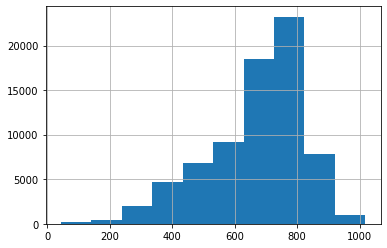

In [27]:
# добавим новый параметр - clients_day, кол-во клиентов в день:
dates_dict = train.app_date.value_counts().to_dict()
train['clients_day'] = train.app_date.map(dates_dict)
test['clients_day'] = train.app_date.map(dates_dict)
train.clients_day.hist()

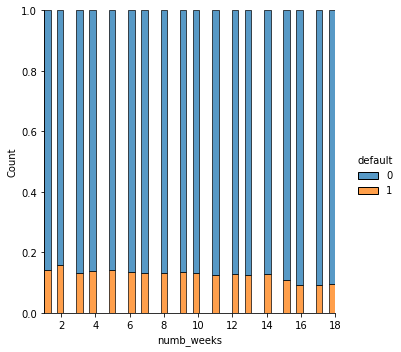

In [28]:
# добавим новый параметр - numb_weeks, номер недели (на основе данных train):
train['numb_weeks'] = train.app_date.dt.week
test['numb_weeks'] = test.app_date.dt.week
sns.displot(train, x="numb_weeks", hue="default", multiple="fill")  # , kind="kde"

In [29]:
# поиск зависимости вероятности дефолта от дня месяца, дня недели или декады результата не дал:
# train['day'] = train.app_date.dt.day
# train['day_of_week'] = train.app_date.dt.dayofweek
# train['decade'] = 0
# train['decade'][train.day <= 10] = 1
# train['decade'][train.day.between(11, 20)] = 2
# train['decade'][train.day > 20] = 3

In [30]:
# теперь можем удалять исходный параметр:
train.drop(['app_date'], axis=1, inplace=True)
test.drop(['app_date'], axis=1, inplace=True)

### 'good_work'

In [31]:
# Посмотрим на пропорции выборки:
print(train.good_work.value_counts(normalize=True)*100)
pd.crosstab(train.good_work, train.default, normalize='index')*100

0    83.510617
1    16.489383
Name: good_work, dtype: float64


default,0,1
good_work,,
0,86.659095,13.340905
1,90.549758,9.450242


##### Присутствует зависимость вероятности дефолта от наличия хорошей работы.

In [32]:
# Проверим пропорции на тестовом наборе:
test.good_work.value_counts(normalize=True)*100

0    83.322787
1    16.677213
Name: good_work, dtype: float64

### 'region_rating'

In [33]:
# Посмотрим на распределение:
pd.crosstab(train.region_rating, train.default, normalize='index')*100

default,0,1
region_rating,,
20,78.640777,21.359223
30,81.000000,19.000000
40,83.029850,16.970150
50,86.385932,13.614068
60,87.116641,12.883359
70,90.756574,9.243426
80,92.684628,7.315372


##### Прослеживается хорошая линейная зависимость.

In [34]:
# посмотрим на пропорции в обучающем и тестовом наборе данных:
print(train.region_rating.value_counts(normalize=True).sort_index()*100)
test.region_rating.value_counts(normalize=True).sort_index()*100

20     0.279137
30     0.406510
40    16.296969
50    37.294543
60    21.782138
70     8.399843
80    15.540861
Name: region_rating, dtype: float64


20     0.294368
30     0.368648
40    16.286555
50    37.024402
60    21.799774
70     8.542188
80    15.684063
Name: region_rating, dtype: float64

### 'work_address'

In [35]:
# Посмотрим на распределение вероятности дефолта:
pd.crosstab(train.work_address, train.default, normalize='index')*100

default,0,1
work_address,,
1,92.584593,7.415407
2,89.749342,10.250658
3,85.204297,14.795703


In [36]:
# Проверим пропорции выборки для обучащей и тестовых выборок:
print(train.work_address.value_counts(normalize=True).sort_index()*100)
test.work_address.value_counts(normalize=True).sort_index()*100

1    11.292836
2    27.786284
3    60.920880
Name: work_address, dtype: float64


1    10.839363
2    28.212606
3    60.948032
Name: work_address, dtype: float64

### 'home_address'

In [37]:
# Посмотрим на пропорции вероятности дефолта:
pd.crosstab(train.home_address, train.default, normalize='index')*100

default,0,1
home_address,,
1,90.710450,9.289550
2,84.485434,15.514566
3,88.394277,11.605723


##### Наблюдается не линейное распределение (с пиком для home_address=2).

In [38]:
# Проверим распределение для обучащей и тестовых выборок:
print(train.home_address.value_counts(normalize=True).sort_index()*100)
test.home_address.value_counts(normalize=True).sort_index()*100

1    44.153715
2    54.141655
3     1.704630
Name: home_address, dtype: float64


1    44.301081
2    54.017992
3     1.680927
Name: home_address, dtype: float64

In [39]:
# учитывая вероятность дефолта для класса home_address=3 (11,6%), логичней поместить его на промежуточный (между 1 и 2):
train.home_address[train.home_address == 3] = 1.5
test.home_address[test.home_address == 3] = 1.5

# # учитывая малое кол-во выборки для класса "3" и низкую вероятность дефолта для этого же класса (11,6%), что ближе к классу "1", можем их объеденить:
# train.home_address[train.home_address == 3] = 1
# test.home_address[test.home_address == 3] = 1

pd.crosstab(train.home_address, train.default, normalize='index')*100

default,0,1
home_address,,
1.0,90.710450,9.289550
1.5,88.394277,11.605723
2.0,84.485434,15.514566


### 'sna'

In [40]:
# Посмотрим на распределение вероятноти дефолта:
pd.crosstab(train.sna, train.default, normalize='index')*100

default,0,1
sna,,
1,90.179912,9.820088
2,85.017881,14.982119
3,84.234780,15.765220
4,78.849264,21.150736


##### Видим, что для групп sna=3 и sna=2 близкие по значению вероятности дефолта.

In [41]:
# посмотрим на пропорции выборки по категориям:
print(train.sna.value_counts(normalize=True).sort_index()*100)
test.sna.value_counts(normalize=True).sort_index()*100

1    64.094364
2    14.398569
3     5.586797
4    15.920270
Name: sna, dtype: float64


1    64.320889
2    14.322265
3     5.587499
4    15.769347
Name: sna, dtype: float64

In [42]:
# # учитывая небольшое кол-во для группы sna=3 и близкое значение вероятности дефолта с группой sna=2 - можем их объеденить
# train.sna = train.sna.apply(lambda x: 2.5 if x in [2, 3] else x)
# test.sna = test.sna.apply(lambda x: 2.5 if x in [2, 3] else x)
# pd.crosstab(train.sna, train.default, normalize='index')*100

### 'first_time'

In [43]:
# Посмотрим на распределение вероятноти дефолта:
pd.crosstab(train.first_time, train.default, normalize='index')*100

default,0,1
first_time,,
1,81.387368,18.612632
2,84.457123,15.542877
3,87.973124,12.026876
4,91.796979,8.203021


In [44]:
# посмотрим на пропорции выборки по категориям:
print(train.first_time.value_counts(normalize=True).sort_index()*100)
test.first_time.value_counts(normalize=True).sort_index()*100

1    16.584236
2    15.675009
3    42.351522
4    25.389233
Name: first_time, dtype: float64


1    16.663457
2    15.623538
3    42.182729
4    25.530276
Name: first_time, dtype: float64

### Итоги анализа ("вероятности дефолта" обозначим как: "ВД"):
* sex - пол заемщика, - не формирует выраженной зависимости ВД;
* car - флаг наличия автомобиля, - рассмотрев совместно с признаком car_type можно утвердать что данный признак не формирует зависимости к ВД;
* car_type - флаг автомобиля иномарки, - формирует хорошо выраженную зависимость ВД;
* foreign_passport - наличие загранпаспорта, - присутствует выраженная зависимость ВД;
* education - уровень образования, - присутствуют пропуски данных; преобразовали категории в соответствущие вероятности дефолта.
* app_date - дата подачи заявки, - на основании сформированно несколько новых признаков с выраженной зависимостью ВД;
* good_work - флаг наличия “хорошей” работы, - присутствует выраженная зависимость ВД;
* region_rating - рейтинг региона, - присутствует выраженная зависимость ВД;
* home_address - категоризатор домашнего адреса, - присутствует выраженная зависимость ВД;
* work_address - категоризатор рабочего адреса, - присутствует выраженная зависимость ВД;
* sna - связь заемщика с клиентами банка - можно отнести к ординальному типу признаков с линейным ростом ВД;
* first_time - давность наличия информации о заемщике - обратная линейная зависимость ВД.

#### 'sex' + 'car' = 'sex_car' - заменим два бесполезных признака на один полезный

In [45]:
pd.crosstab([train.sex, train.car], train.default, normalize='index')*100

default          0          1
sex car                      
0   0    87.243951  12.756049
    1    90.260710   9.739290
1   0    84.484891  15.515109
    1    88.866317  11.133683

In [46]:
train['sex_car'] = 0
train['sex_car'][(train.car == 1)&(train.sex == 0)] = 1
train['sex_car'][(train.car == 1)&(train.sex == 1)] = 2
train['sex_car'][(train.car == 0)&(train.sex == 0)] = 3
train['sex_car'][(train.car == 0)&(train.sex == 1)] = 4

test['sex_car'] = 0
test['sex_car'][(test.car == 1)&(test.sex == 0)] = 1
test['sex_car'][(test.car == 1)&(test.sex == 1)] = 2
test['sex_car'][(test.car == 0)&(test.sex == 0)] = 3
test['sex_car'][(test.car == 0)&(test.sex == 1)] = 4

pd.crosstab(train.sex_car, train.default, normalize='index')*100

default,0,1
sex_car,,
1,90.260710,9.739290
2,88.866317,11.133683
3,87.243951,12.756049
4,84.484891,15.515109


In [47]:
# Удалим ранее отбракованные (или оптимизированные в новые признаки) данные:
train.drop(['sex', 'car'], axis=1, inplace=True)  # 
test.drop(['sex', 'car'], axis=1, inplace=True)   # 

## 3. Анализ и обработка числовых признаков:

### 'client_id'

In [48]:
# Убедимся что все записи уникальны (train + test):
id_all = train.client_id.append(test.client_id)
id_all.shape[0] == id_all.nunique()

True

In [49]:
# заметив что у client_id почти 100% корреляция с параметром month, проверим его очередность:
train.sort_values('client_id')

,client_id,education,age,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,clients_day,numb_weeks,sex_car
24222,1,15.06,27,1,0,0,-1.917831,0,40,2.0,3,32000,1,4,0,0,1,43,1,2
4824,2,9.01,26,0,0,0,-1.153144,2,60,2.0,3,50000,2,1,0,0,1,43,1,3
62792,3,15.06,35,0,0,1,-1.732810,0,40,1.0,2,20000,4,3,0,0,1,43,1,4
10525,5,13.15,24,0,0,0,-1.914581,1,50,2.0,3,27000,1,2,0,0,1,43,1,3
57653,6,15.06,35,1,0,0,-1.920823,4,40,2.0,3,35000,4,3,0,0,1,43,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14007,110142,15.06,48,0,0,1,-2.064421,3,80,2.0,3,60000,1,2,0,0,4,584,18,4
56358,110143,9.01,42,0,0,0,-1.864372,2,50,2.0,3,70000,1,4,0,0,4,584,18,3
61140,110145,9.01,39,0,0,0,-1.682339,2,40,2.0,3,30000,1,4,0,0,4,584,18,3
48975,110146,13.15,27,0,0,1,-2.497592,0,80,2.0,3,60000,1,1,0,0,4,584,18,2


##### Делаем вывод, что данный параметр соответствует порядковому номеру подачи заявки клиентом (начиная с 01.01.2014 и заканчивая 30.04.2014). Данный параметр не несет ни какой фундаментальной (логической) ценности для выявления закономерности по вероятности дефолта.

### 'age'

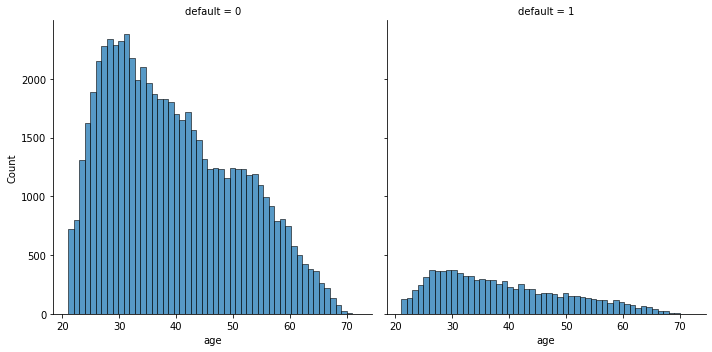

In [50]:
# Посмотрим на возрастное распределение по дефолтам:
sns.displot(train, x="age", col="default", bins=52)

<AxesSubplot:xlabel='age', ylabel='default_%'>

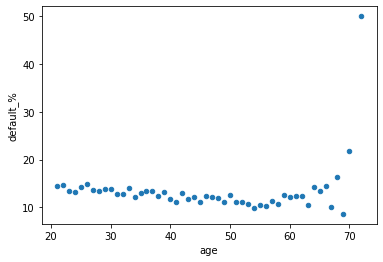

In [51]:
# Для адекватного восприятия данного распределения (дефолтов по возрасту) - приведем расчеты к относительному виду, (%):
df_age = pd.DataFrame()
df_age['default_0'] = train.age[train.default == 0].value_counts()
df_age['default_1'] = train.age[train.default == 1].value_counts()
df_age['default_%'] = df_age['default_1'] / (df_age['default_0'] + df_age['default_1']) * 100
df_age['age'] = df_age.index

# видим параболическую зависимость вероятности дефолта от возраста (c минимумом в области 55 лет и возрастанием по краям диапазона):
df_age.plot(x='age', y='default_%', kind='scatter')

<AxesSubplot:xlabel='age', ylabel='%%'>

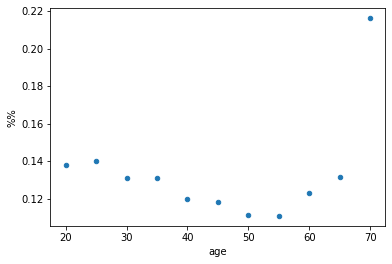

In [52]:
# для лучшей апроксимации сгладим статистику объеденив в группы по 5-летним диапазонам:
df_age.age = df_age.age.apply(lambda x: (x // 5) * 5)
df_age_group5 = df_age.groupby(['age'])[['default_0', 'default_1']].sum()
df_age_group5['%%'] = df_age_group5['default_1'] / (df_age_group5['default_0'] + df_age_group5['default_1'])
df_age_group5['age'] = df_age_group5.index
df_age_group5.plot(x='age', y='%%', kind='scatter')

In [53]:
# используем данные вероятности дефолта для возрастных групп в обучающем и тестовом наборах данных:
dict_default_by_age = round(df_age_group5['%%']*100, 3).to_dict()

# проведем преобразование:
train['age'] = train.age.apply(lambda x: (x // 5) * 5).map(dict_default_by_age)
test['age'] = test.age.apply(lambda x: (x // 5) * 5).map(dict_default_by_age)

### 'decline_app_cnt'

In [54]:
# Посмотрим какое имеем колличественное распределение:
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
14        2
12        2
16        2
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

In [55]:
# сгруппируем малочисленные группы и посмотрим на вероятности дефолтов:
train.decline_app_cnt[train.decline_app_cnt > 3] = 3
test.decline_app_cnt[test.decline_app_cnt > 3] = 3
pd.crosstab(train.decline_app_cnt, train.default, normalize='index')*100

default,0,1
decline_app_cnt,,
0,89.046623,10.953377
1,81.219483,18.780517
2,75.648298,24.351702
3,71.569767,28.430233


In [56]:
# # другие варианты группировок и dummy-разложения не принесли улучшения значения для f1:
# train = pd.get_dummies(train, columns=['decline_app_cnt'])
# test = pd.get_dummies(test, columns=['decline_app_cnt'])

# # создадим словарь вероятности дефолта для соответствующих группировок (по кол-ву предыдущих отказов):
# dict_default_by_decline_app_cnt = pd.crosstab(train.decline_app_cnt, train.default, normalize='index')*100

# # добавим параметр характеризующий вероятность дефолта для соответствующей группы "количества отказанных прошлых заявок":
# train['decline_app_cnt'] = train.decline_app_cnt .map(dict_default_by_decline_app_cnt.iloc[:, -1])
# test['decline_app_cnt'] = test.decline_app_cn.map(dict_default_by_decline_app_cnt.iloc[:, -1])
# train.decline_app_cnt.value_counts(normalize=True)*100

### 'score_bki'

<AxesSubplot:xlabel='score_bki', ylabel='Density'>

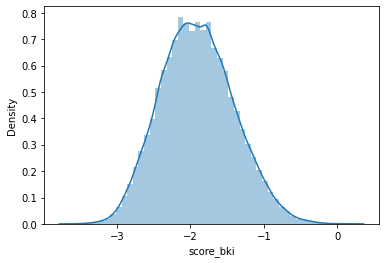

In [57]:
# Посмотрим на распределение:
sns.distplot(train.score_bki)

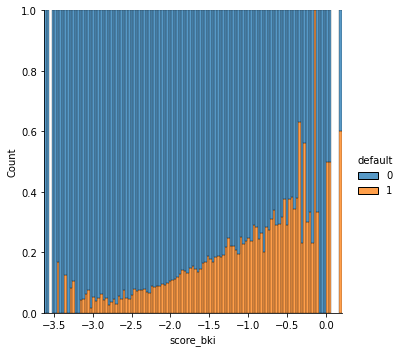

In [58]:
sns.displot(train, x="score_bki", hue="default", multiple="fill")  # , kind="kde"

##### Видим, что на малочисленных хвостах ((-4;-3) и (-0.5;0.2))  присутствуют разброд и шатания.
##### Но попытка произвести обработку для сглаживания распределения не привела к улучшению точности модели.

In [59]:
# # сгрупируем левый хвост:
# train.score_bki[train.score_bki < - 3.5] = - 3.5
# test.score_bki[test.score_bki < - 3.5] = - 3.5

# # произведем сглаживание данных с шагом 0.2:
# train.score_bki = train.score_bki.apply(lambda x: (x*10//2)/5)
# test.score_bki = test.score_bki.apply(lambda x: (x*10//2)/5)
# # произведем сглаживание данных с шагом 0.1:
# train.score_bki = train.score_bki.apply(lambda x: x*10//1/10)
# test.score_bki = test.score_bki.apply(lambda x: x*10//1/10)

# # предположим что значения больше 0 - это ошибка и исправим для них знак:
# train.score_bki[train.score_bki > 0] = - train.score_bki
# test.score_bki[test.score_bki > 0] = - test.score_bki

# sns.displot(train, x="score_bki", hue="default", multiple="fill")

### 'bki_request_cnt'

In [60]:
# Посмотрим на распределение:
pd.crosstab(train.bki_request_cnt, train.default)

default,0,1
bki_request_cnt,,
0,17540,1841
1,16105,2171
2,11929,1820
3,7849,1338
4,4776,851
5,2714,554
6,1425,279
7,718,134
8,410,98


In [61]:
# Проведем группировку кол-ва запросов для балансировки и сглаживания зависимости:
train.bki_request_cnt[train.bki_request_cnt > 16] = 16
train.bki_request_cnt[train.bki_request_cnt.between(11, 15)] = 11
train.bki_request_cnt[train.bki_request_cnt.between(8, 10)] = 8
train.bki_request_cnt[train.bki_request_cnt.between(4, 7)] = 4

test.bki_request_cnt[test.bki_request_cnt > 16] = 16
test.bki_request_cnt[test.bki_request_cnt.between(11, 15)] = 11
test.bki_request_cnt[test.bki_request_cnt.between(8, 10)] = 8
test.bki_request_cnt[test.bki_request_cnt.between(4, 7)] = 4

pd.crosstab(train.bki_request_cnt, train.default, normalize='index')*100

default,0,1
bki_request_cnt,,
0,90.501006,9.498994
1,88.121033,11.878967
2,86.762674,13.237326
3,85.435942,14.564058
4,84.123657,15.876343
8,81.007752,18.992248
11,75.265018,24.734982
16,69.426752,30.573248


### 'income'

<AxesSubplot:xlabel='income', ylabel='Density'>

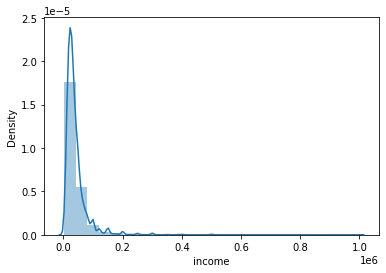

In [62]:
# Посмотрим на распределение доходов:
sns.distplot(train.income, bins=25)

<AxesSubplot:xlabel='income', ylabel='Density'>

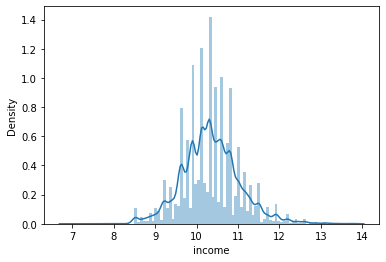

In [63]:
# Без логарифмического преобразования тут не обойтись:
train['income'] = np.log(train['income'] + 1)
test['income'] = np.log(test['income'] + 1)

sns.distplot(train.income, bins=100)

In [64]:
# произведем сглаживание данных с шагом 0.5:
train.income = train.income.apply(lambda x: ((x * 10) // 5) / 2)
test.income = test.income.apply(lambda x: ((x * 10) // 5) / 2)

# Проведем группировки для сглаживания зависимости:
train.income[train.income < 8.5] = 8.5
test.income[test.income < 8.5] = 8.5
train.income[train.income > 12] = 12
test.income[test.income > 12] = 12

pd.crosstab(train.income, train.default, normalize='index')*100

default,0,1
income,,
8.5,86.313131,13.686869
9.0,86.045549,13.954451
9.5,84.940284,15.059716
10.0,86.288477,13.711523
10.5,88.840448,11.159552
11.0,90.699746,9.300254
11.5,91.998774,8.001226
12.0,90.238095,9.761905


In [65]:
# # Попытка развернуть параболу к линейному виду, не привела к улучшению ф-меры на тесте:
# train.income = abs(train.income - 9.5)
# test.income = abs(test.income - 9.5)
# pd.crosstab(train.income, train.default, normalize='index')*100

### Итоги анализа ("вероятности дефолта" обозначим как: "ВД"):
* client_id - идентификатор клиента - не имеет смысла, просто порядковый номер клиента;
* age - возраст заемщика - формирует параболическую зависимость ВД с минимумом в районе 55 лет и резким ростом после 70 лет;
* decline_app_cnt - количество отказанных прошлых заявок - хорошо выраженная зависимость ВД, наблюдается практический линейный рост;
* score_bki - скоринговый балл по данным из БКИ - имеет структуру нормального распределения, формирует параболическую зависимость ВД с минимумов в районе -2,8 и бОльшим максимумом в правом хвосте;
* bki_request_cnt - количество запросов в БКИ - повторяет зависимость как и у параметра decline_app_cnt, - практический линейный рост;
* income - доход заемщика - после логарифмического преобразования имеет структуру нормального распределения, но при этом зависимсоть ВД носит не линейный характер;

In [66]:
# Удалим ранее отбракованные (или оптимизированные в новые признаки) данные:
train.drop(['client_id'], axis=1, inplace=True)  # 
test.drop(['client_id'], axis=1, inplace=True)   # 

## 4. Матрица корреляции и оценка значимости:

<AxesSubplot:>

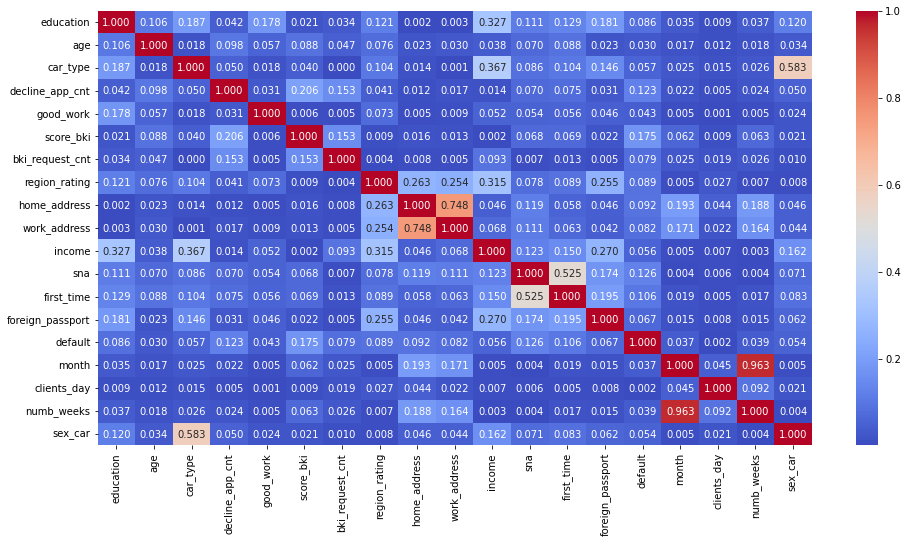

In [67]:
plt.figure(figsize=(16, 8))
sns.heatmap(train.corr().abs(), annot=True, cmap='coolwarm', fmt='.3f', annot_kws={'size':10})

In [68]:
# Для оценки значимости переменных будем использовать функцию mutual_info_classif:
imp_cat = pd.Series(mutual_info_classif(train.drop(columns='default', axis=1), train['default'], 
                                        discrete_features='auto', random_state=100), 
                    index=train.drop(columns='default', axis=1).columns.values)
imp_cat.sort_values()

numb_weeks          0.000000
good_work           0.000611
clients_day         0.001377
car_type            0.001695
foreign_passport    0.002092
age                 0.004395
region_rating       0.004749
sex_car             0.004859
bki_request_cnt     0.005133
income              0.005393
month               0.005761
education           0.008598
decline_app_cnt     0.008598
work_address        0.008674
first_time          0.009085
sna                 0.011342
home_address        0.012215
score_bki           0.016763
dtype: float64

In [69]:
# Учитывая высокую корреляцию между 'month' и 'numb_weeks', и отсутствие "значимости" для 'numb_weeks', - удалим последний:
train.drop(['numb_weeks'], axis=1, inplace=True)   
test.drop(['numb_weeks'], axis=1, inplace=True)

## 5. Feature Engineering:

##### Синтетическая генерация новых признаков (из имеющихся) не увенчалась положительной прибавкой для f1.

In [70]:
# # Разобъем оставшиеся признаки на три категории:
# columns_bins = ['car_type', 'good_work', 'home_address', 'work_address', 'sna', 'first_time', 'foreign_passport', 'month']
# columns_cat = ['education', 'age', 'decline_app_cnt', 'region_rating', 'income']
# columns_numb = ['score_bki', 'clients_day', 'defaults_day', 'numb_weeks', 'bki_request_cnt']

# # На основании этих категорий сформируем комбинации:
# bins_3 = list(combinations(columns_bins, 3))
# cat_3 = list(combinations(columns_cat, 3))
# numb_3 = list(combinations(columns_numb, 3))

# print('combinations(columns_bins, 3): ', len(bins_3))
# print('combinations(columns_cat, 3): ', len(cat_3))
# print('combinations(columns_numb, 3): ', len(numb_3))

In [71]:
# # 1. Добавим весь перечень синтезированных парметров bins_3:
# for x, y, z in bins_3:
#     train['dif1_' + str(x) + str(y) + str(z)] = train[x] + train[y] - train[z]
#     train['dif2_' + str(x) + str(y) + str(z)] = train[x] - train[y] + train[z]
#     train['dif3_' + str(x) + str(y) + str(z)] = train[x] - train[y] - train[z]

# # 2. С помощью mutual_info_classif отберем лучшие из новых параметров:
# dif1_home_address sna foreign_passport    0.016630
# dif2_car_type home_address first_time     0.015406
# dif3_car_type work_address sna            0.015467

# 3. Добавим новые параметры в train и test:
# train['1'] = train['home_address'] + train['sna'] - train['foreign_passport']
# train['2'] = train['car_type'] - train['home_address'] + train['first_time']
# train['3'] = train['car_type'] - train['work_address'] - train['sna']
# test['1'] = test['home_address'] + test['sna'] - test['foreign_passport']
# test['2'] = test['car_type'] - test['home_address'] + test['first_time']
# test['3'] = test['car_type'] - test['work_address'] - test['sna']

In [72]:
# # 1. Добавим весь перечень синтезированных парметров cat_3:
# for x, y, z in cat_3:
#     train['dif1_' + str(x) + str(y) + str(z)] = train[x] + train[y] - train[z]
#     train['dif2_' + str(x) + str(y) + str(z)] = train[x] - train[y] + train[z]
#     train['dif3_' + str(x) + str(y) + str(z)] = train[x] - train[y] - train[z]
#     train['mult1_' + str(x) + str(y) + str(z)] = (train[x] - train[y]) / (train[x] + train[y])
#     train['mult2_' + str(x) + str(y) + str(z)] = (train[x] - train[z]) / (train[x] + train[z])
#     train['mult3_' + str(x) + str(y) + str(z)] = (train[y] - train[z]) / (train[y] + train[z])
    
    
# # 2. С помощью mutual_info_classif отберем лучшие из новых параметров:
# dif3_education decline_app_cnt region_rating     0.015614

# # 3. Добавим новые параметры в train и test:
# train['4'] = train['decline_app_cnt'] - train['bki_request_cnt'] - train['education']
# train['5'] = train['decline_app_cnt'] * train['education']
# test['4'] = test['decline_app_cnt'] - test['bki_request_cnt'] - test['education']
# test['5'] = test['decline_app_cnt'] * test['education']

In [73]:
# # 1. Добавим весь перечень синтезированных парметров numb_3:
# for x, y, z in numb_3:
#     train['dif1_' + str(x) + str(y) + str(z)] = train[x] + train[y] - train[z]
#     train['dif2_' + str(x) + str(y) + str(z)] = train[x] - train[y] + train[z]
#     train['dif3_' + str(x) + str(y) + str(z)] = train[x] - train[y] - train[z]
#     train['mult1_' + str(x) + str(y) + str(z)] = pow(abs((train[x] - train[y]) * train[z]), 0.5)
#     train['mult2_' + str(x) + str(y) + str(z)] = pow(abs((train[x] - train[z]) * train[y]), 0.5)
#     train['mult3_' + str(x) + str(y) + str(z)] = pow(abs((train[y] - train[z]) * train[x]), 0.5)

# # 2. С помощью mutual_info_classif отберем лучшие из новых параметров:
# mult1_score_bki clients_day numb_weeks         0.016457
# mult_score_bki income                      0.018898
# sum_score_bki region_rating                0.022869

# # 3. Добавим новые параметры в train и test:
# train['6'] = train['score_bki'] + train['clients_day']
# train['7'] = train['score_bki'] * train['income']
# train['8'] = train['score_bki'] + train['region_rating']
# test['6'] = test['score_bki'] + test['clients_day']
# test['7'] = test['score_bki'] * test['income']
# test['8'] = test['score_bki'] + test['region_rating']

In [74]:
# imp_cat = pd.Series(mutual_info_classif(train.drop(columns='default', axis=1), train['default'], 
#                                         discrete_features='auto', random_state=100), 
#                     index=train.drop(columns='default', axis=1).columns.values)
# imp_cat.sort_values()

## 6. Нормализация и балансировка обучающей выборки:

In [75]:
# Проведем нормализацию обработанных параметров:
scaler=RobustScaler()    # на test показал слегка лучше результат, чем MinMaxScaler()
columns = train.drop(columns='default', axis=1).columns.values
train[columns] = scaler.fit_transform(train.drop(columns='default', axis=1).values)
test[columns] = scaler.transform(test.values)

# Для балансировки (класса default=1) разделим нашу выборку train на обучающую и валидационну):
X = train.drop(columns='default', axis=1)
y = train['default'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=SEED)

# Протестируем два варианта балансировки:
# 1. RandomOverSampler расширения выборки:
from imblearn.over_sampling import RandomOverSampler
oversam = RandomOverSampler(sampling_strategy='minority', random_state=SEED)
X_over, y_over = oversam.fit_resample(X_train, y_train)

# 2. SMOTE расширения выборки:
from imblearn.over_sampling import SMOTE
smot = SMOTE(sampling_strategy='minority', random_state=SEED)
X_smot, y_smot = smot.fit_resample(X_train, y_train)

X_train.shape, X_over.shape, X_smot.shape

((59039, 17), (103142, 17), (103142, 17))

## 7. Подбор гиперпараметров:

In [76]:
C = np.logspace(0, -2, 10)       # [1, 1e-1, 1e-2, 1e-3]
iters = [15, 25, 50, 75]
epsilon_stop = [1e-4]
class_weight = [None]         # выбрать в случаи подбора параметров для сбалансированных выборок
# class_weight = ['balanced']   # для несбалансированной выборки
param_grid = [
    {'C': C,
     'penalty': ['l1'],
     'solver': ['liblinear'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol': epsilon_stop},
    {'C': C,
     'penalty': ['l2'],
     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop},
    {'C': C,
     'penalty': ['elasticnet'],
     'solver': ['saga'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop},
    {'C': ['none'],
     'penalty': ['none'],
     'solver': ['lbfgs', 'sag'],
     'class_weight': class_weight,
     'multi_class': ['auto'],
     'max_iter': iters,
     'tol':epsilon_stop}]

##### Далее код скрыт, так как его выполнение занимает много времени, а параметры уже зафиксированны.

In [77]:
# Разбиение на обучающую и валидационную часть, используя один из двух вариантов расширения:
# X_train, y_train = X_over, y_over
# X_train, y_train = X_smot, y_smot

# model = LogisticRegression()  # solver='liblinear'
# model.fit(X_train, y_train)

# # Произведем поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке param_grid:
# grid_search = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)
# # grid_search.best_params_

# # Печатаем параметры развернуто:
# best_model = grid_search.best_estimator_
# best_parameters = best_model.get_params()
# for param_name in sorted(best_parameters.keys()):
#     print('\t%s: %r' % (param_name, best_parameters[param_name]))

### Выбор одного из вариантов обучающей выборки и соотвествующих подобранных гиперпараметров:

In [78]:
# 1. Изначальная обучающая выборка train с соответствующими гиперпараметрами:
# X, y = X_train, y_train
# model = LogisticRegression(C=1, class_weight='balanced', max_iter=75, penalty='none', solver='sag', tol=1e-4, multi_class='auto')

# 2. Расширение обучающего датасэта с помощью RandomOverSampler и соответствующие оптипальные гиперпараметры под него:
X, y = X_over, y_over
model = LogisticRegression(C=1e-1, class_weight=None, max_iter=50, penalty='l2', solver='liblinear', tol=1e-4, multi_class='auto')
# model = LogisticRegression(C=1e-2, class_weight=None, max_iter=25, penalty='l2', solver='lbfgs', tol=1e-4, multi_class='auto')

# 3. Расширение обучающего датасэта с помощью SMOTE (и соответствующие оптипальные гиперпараметры под него):
# X, y = X_smot, y_smot
# model = LogisticRegression(C=1e-1, class_weight=None, max_iter=100, penalty='l2', solver='newton-cg', tol=1e-4, multi_class='auto')

## 8. Обучение модели:

### Проверка на наличие паразитных параметров:

##### Проверив на test видим, что исключение любого из оставшихся параметров ухудшает результат расчета модели по f1.

In [79]:
# # Для начала зафиксируем результат по метрике f1 (с порогом отсечения 0,5):
# model_check = model
# model_check.fit(X, y)
# y_pred = model_check.predict(X_valid)
# f1_score(y_valid, y_pred).T

In [80]:
# # Определившись с выбором гиперпараметров и вариантом обучающей выборки еще раз проверим, исключая каждый параметры по очереди, что паразитных не осталось:
# dict_exc_param = {}
# for param in X.columns.values:
#     model_check_1 = model
#     model_check_1.fit(X.drop(columns=param, axis=1), y)
#     y_pred = model_check_1.predict(X_valid.drop(columns=param, axis=1))
#     dict_exc_param[param] = f1_score(y_valid, y_pred).T

# # Напечатаем трое наилучших f1 с соответствующими исключенными параметрами:
# sorted(dict_exc_param.items(), key=lambda x: -x[1])[:7]

### Проверим выбранную модель с тремя разными вариантами разбиения обучающей выборки:

### 1. LogisticRegression + TrainTestSplit

In [81]:
model_LR = model
model_LR.fit(X, y)
y_pred_proba = model_LR.predict_proba(X_valid)

matrix = pd.DataFrame()
res = pd.DataFrame(y_pred_proba[:, 1], columns=['prob'])

for threshold in range(50, 65, 1):  # 50, 70, 1
    y_pred_cut = res.prob.apply(lambda x: 1 if x >= threshold/100 else 0)
    T_def_0, F_def_0, F_def_1, T_def_1 = confusion_matrix(y_valid, y_pred_cut).ravel()
    f1 = f1_score(y_valid, y_pred_cut.values).T
    BAS = balanced_accuracy_score(y_valid, y_pred_cut.values)
    matrix = matrix.append(pd.DataFrame(data=[[T_def_0, F_def_0, F_def_1, T_def_1, f1, BAS]], 
                                        columns=['T_def_0', 'F_def_0', 'F_def_1', 'T_def_1', 'f1_score', 'BAS'], 
                                        index=[threshold/100]))

matrix['profit'] = matrix.T_def_0 - matrix.F_def_0 + matrix.T_def_1 - 8 * matrix.F_def_1

# Три лучших результата (по метрике f1) будем записывать в новую таблицу:
top3_model_LR = matrix.sort_values(by='f1_score', ascending=False).iloc[:3]

matrix

,T_def_0,F_def_0,F_def_1,T_def_1,f1_score,BAS,profit
0.50,8599,4257,608,1296,0.347593,0.674771,774
0.51,8822,4034,643,1261,0.350326,0.674253,905
0.52,9032,3824,674,1230,0.353550,0.674280,1046
0.53,9232,3624,709,1195,0.355496,0.672867,1131
0.54,9415,3441,737,1167,0.358415,0.672632,1245
0.55,9571,3285,780,1124,0.356091,0.667407,1170
0.56,9767,3089,816,1088,0.357836,0.665576,1238
0.57,9940,2916,847,1057,0.359707,0.664163,1305
0.58,10109,2747,879,1025,0.361170,0.662333,1355
0.59,10254,2602,921,983,0.358171,0.656943,1267


In [82]:
max_f1 = matrix[matrix.f1_score == matrix.f1_score.max()].index
y_pred_prob = pd.DataFrame(model_LR.predict_proba(X_valid))
y_pred = y_pred_prob.iloc[:, -1].apply(lambda x: 1 if x >= max_f1 else 0)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     12856
           1       0.27      0.54      0.36      1904

    accuracy                           0.75     14760
   macro avg       0.60      0.66      0.60     14760
weighted avg       0.84      0.75      0.79     14760



### Построим ROC_AUC:

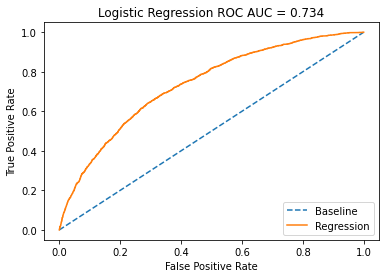

In [83]:
y_pred_proba = model_LR.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, y_pred_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

### Проверка модели на переобучение:

[train] F1-score = 0.67 +/- 0.00
[valid] F1-score = 0.67 +/- 0.00


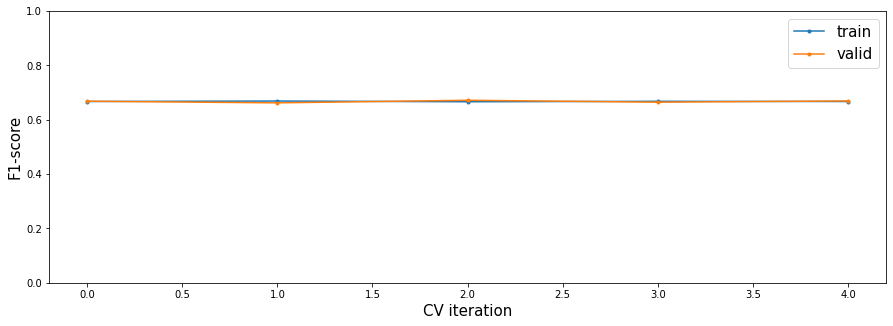

In [84]:
# Чтобы проверить наличие переобученния модели воспользуемся функцией cross_validate:
cv_metrics = cross_validate(model_LR, X, y, cv=5, scoring='f1_micro', return_train_score=True)

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
plot_cv_metrics(cv_metrics)

### 2. LogisticRegression + StratifiedShuffleSplit

In [85]:
SPLIT = 10   # используем для StratifiedShuffleSplit и KFold

In [86]:
model_LR_sss = model
sss = StratifiedShuffleSplit(n_splits=SPLIT, random_state=SEED)

train_index, valid_index = [split for split in sss.split(X, y)][0]

X_train_sss = X.iloc[train_index, :]
y_train_sss = y[train_index]
X_valid_sss = X.iloc[valid_index, :]
y_valid_sss = y[valid_index]

model_LR_sss.fit(X_train_sss, y_train_sss)
y_pred_proba = model_LR_sss.predict_proba(X_valid)

matrix = pd.DataFrame()
res = pd.DataFrame(y_pred_proba[:, 1], columns=['prob'])

for threshold in range(50, 65, 1):
    y_pred_cut = res.prob.apply(lambda x: 1 if x >= threshold/100 else 0)
    T_def_0, F_def_0, F_def_1, T_def_1 = confusion_matrix(y_valid, y_pred_cut).ravel()
    f1 = f1_score(y_valid, y_pred_cut.values).T
    BAS = balanced_accuracy_score(y_valid, y_pred_cut.values)
    matrix = matrix.append(pd.DataFrame(data=[[T_def_0, F_def_0, F_def_1, T_def_1, f1, BAS]], 
                                        columns=['T_def_0', 'F_def_0', 'F_def_1', 'T_def_1', 'f1_score', 'BAS'], 
                                        index=[threshold/100]))

matrix['profit'] = matrix.T_def_0 - matrix.F_def_0 + matrix.T_def_1 - 8 * matrix.F_def_1

# Будем записывать три лучших результата (по метрике f1) в новую таблицу:
top3_model_LR_sss = matrix.sort_values(by='f1_score', ascending=False).iloc[:3]
matrix

,T_def_0,F_def_0,F_def_1,T_def_1,f1_score,BAS,profit
0.50,8595,4261,611,1293,0.346742,0.673828,739
0.51,8821,4035,642,1262,0.350507,0.674477,912
0.52,9028,3828,669,1235,0.354528,0.675437,1083
0.53,9234,3622,709,1195,0.355602,0.672945,1135
0.54,9414,3442,736,1168,0.358612,0.672855,1252
0.55,9574,3282,776,1128,0.357301,0.668574,1212
0.56,9764,3092,814,1090,0.358199,0.665984,1250
0.57,9938,2918,847,1057,0.359585,0.664086,1301
0.58,10101,2755,884,1020,0.359218,0.660709,1294
0.59,10262,2594,922,982,0.358394,0.656991,1274


In [87]:
max_f1 = matrix[matrix.f1_score == matrix.f1_score.max()].index
y_pred_prob = pd.DataFrame(model_LR_sss.predict_proba(X_valid))
y_pred = y_pred_prob.iloc[:, -1].apply(lambda x: 1 if x >= max_f1 else 0)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84     12856
           1       0.27      0.56      0.36      1904

    accuracy                           0.74     14760
   macro avg       0.59      0.66      0.60     14760
weighted avg       0.84      0.74      0.78     14760



### 3. LogisticRegression + KFold

In [88]:
model_LR_kf = model
kf = KFold(n_splits=SPLIT, shuffle=True, random_state=SEED)

for train_index, test_index in kf.split(X, y):
    X_train_kf = X.iloc[train_index, :]
    y_train_kf = y[train_index]
    X_test_kf = X.iloc[test_index, :]
    y_test_kf = y[test_index]
    model_LR_kf.fit(X_train_kf, y_train_kf)

y_pred_proba = model_LR_kf.predict_proba(X_valid)

matrix = pd.DataFrame()
res = pd.DataFrame(y_pred_proba[:, 1], columns=['prob'])

for threshold in range(50, 65, 1):
    y_pred_cut = res.prob.apply(lambda x: 1 if x >= threshold/100 else 0)
    T_def_0, F_def_0, F_def_1, T_def_1 = confusion_matrix(y_valid, y_pred_cut).ravel()
    f1 = f1_score(y_valid, y_pred_cut.values).T
    BAS = balanced_accuracy_score(y_valid, y_pred_cut.values)
    matrix = matrix.append(pd.DataFrame(data=[[T_def_0, F_def_0, F_def_1, T_def_1, f1, BAS]], 
                                        columns=['T_def_0', 'F_def_0', 'F_def_1', 'T_def_1', 'f1_score', 'BAS'], 
                                        index=[threshold/100]))

matrix['profit'] = matrix.T_def_0 - matrix.F_def_0 + matrix.T_def_1 - 8 * matrix.F_def_1

# Будем записывать три лучших результата (по метрике f1) в новую таблицу:
top3_model_LR_kf = matrix.sort_values(by='f1_score', ascending=False).iloc[:3]
matrix

,T_def_0,F_def_0,F_def_1,T_def_1,f1_score,BAS,profit
0.50,8610,4246,615,1289,0.346552,0.673361,733
0.51,8825,4031,644,1260,0.350243,0.674107,902
0.52,9040,3816,676,1228,0.353483,0.674066,1044
0.53,9240,3616,710,1194,0.355675,0.672916,1138
0.54,9411,3445,737,1167,0.358195,0.672476,1237
0.55,9591,3265,779,1125,0.357483,0.668447,1219
0.56,9775,3081,815,1089,0.358578,0.666150,1263
0.57,9948,2908,851,1053,0.359079,0.663424,1285
0.58,10118,2738,879,1025,0.361743,0.662683,1373
0.59,10262,2594,924,980,0.357795,0.656466,1256


In [89]:
max_f1 = matrix[matrix.f1_score == matrix.f1_score.max()].index
y_pred_prob = pd.DataFrame(model_LR_kf.predict_proba(X_valid))
y_pred = y_pred_prob.iloc[:, -1].apply(lambda x: 1 if x >= max_f1 else 0)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     12856
           1       0.27      0.54      0.36      1904

    accuracy                           0.75     14760
   macro avg       0.60      0.66      0.61     14760
weighted avg       0.84      0.75      0.79     14760



## 9. Submission

In [90]:
# Выбирем лучшую модель и порог отсечения:
top_score_df = pd.DataFrame()
top_score_df = pd.concat([top3_model_LR, top3_model_LR_sss, top3_model_LR_kf], keys=['model_LR', 'model_LR_sss', 'model_LR_kf'])
top_score_df

T_def_0  F_def_0  F_def_1  T_def_1  f1_score       BAS  profit
model_LR     0.58    10109     2747      879     1025  0.361170  0.662333    1355
             0.57     9940     2916      847     1057  0.359707  0.664163    1305
             0.54     9415     3441      737     1167  0.358415  0.672632    1245
model_LR_sss 0.57     9938     2918      847     1057  0.359585  0.664086    1301
             0.58    10101     2755      884     1020  0.359218  0.660709    1294
             0.54     9414     3442      736     1168  0.358612  0.672855    1252
model_LR_kf  0.58    10118     2738      879     1025  0.361743  0.662683    1373
             0.57     9948     2908      851     1053  0.359079  0.663424    1285
             0.56     9775     3081      815     1089  0.358578  0.666150    1263

In [91]:
# Лучшие полученные результаты по f1 на валидации (но с ухудшением на test):
# 0.362998 - model_LR
# 0.364388 - model_LR_sss
# 0.363171 - model_LR_kf

In [92]:
# На основании рассчитаных ранее результатов по f1 выберем соответвующую модель и порог отсечения:
threshold_cut = 0.588 # загрузив несколько раз submission установим более точно порог отсечения.
predict_submission = model_LR.predict_proba(test)    # X_Over, 0.588; f1=0.35401
# predict_submission = model_LR_sss.predict_proba(test)  
# predict_submission = model_LR_kf.predict_proba(test)

# Загружаем итоговый расчет в 'submission.csv':
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
sample_submission['default'] = predict_submission[:, -1]
sample_submission['default'] = sample_submission['default'].apply(lambda x: 1 if x >= threshold_cut else 0)
sample_submission.to_csv('submission.csv', index=False)

print(sample_submission.shape)
sample_submission.head(5)

(36349, 2)


,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0


## 10. Выводы:

Достич максимального результата в 0,35554 (submission на test) фактически удалось за счет следующих действий:
* обработка первичных признаков (группировок, преобразования категориальных в ординальные или числовые признаки), создания новых признаков ('month', 'sex_car') и удаления не эффективных ('client_id', 'car', 'sex');
* нормализации всей выборки (RobustScaler) и балансировки обучающей выборки (RandomOverSampler);
* применения модели LogisticRegression и подбор гиперпараметров методом GridSearchCV;
* определением оптимального порого отсечения вероятности дефолта (благодарность за подсказку - Daniil Martsenyuk).

При этом было затрачено огромное кол-во времени в попытках улучшить качество прогноза модели (наверное около 90% от общего затраченного времени), но практически с нулевым результатом (или на уровне прироста +0,001-0,002). Проблема заключалось в том что при определенных изменениях в обработке данных получал прирост f1 для валидационной выборки (до 0,364), но при этом одновременно получал ухудшение результата на итоговом наборе данных (test), что требовало фактически проверки каждого незначительного изменения на submission. Так же усложняло задачу то что для валидационной выборки оптимальный порог отсечения определялся на уровне 0,56-0,57, в то время как для итогового набора данных оптимальный порог отсечения находился в районе 0,59.